In [1]:
import pandas as pd
import numpy as np
import sklearn
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import emoji
import tensorflow_hub
import tensorflow as tf
import tensorflow_text
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
from dtw import *
from sklearn.preprocessing import MaxAbsScaler

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
##FUNCTIONS

def get_sentiment_timeseries(data_f,column):

    ####################
    comp_list_news = []
    for sentence in data_f[column]:
        pol_scores = SentimentIntensityAnalyzer().polarity_scores(sentence)
        #print("{} {} {:}".format(str( vs['compound']),"  | <- compound score, the tweet -> " ,sentence))
        comp = pol_scores['compound']
        if comp >= 0.05:
            comp = 1
        elif comp <= -0.05:
            comp = -1
        else:
            comp = 0
        comp_list_news.append(comp)
        #print("{} {} {:}".format(str( compound_score),"| <- compound score, the tweet ->: " ,sentence))
    return comp_list_news


def get_model_sentiment_timeseries(data_f,column):
    import pandas as pd
    import numpy as np
    import sklearn
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MaxAbsScaler
    # read and drop nan values
    pathh = 'Data/tweets/PrelabelData.csv'
    df = pd.read_csv(pathh)
    df = df.dropna()
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.2)
    # Vectorize the data
    Cvec = CountVectorizer()
    X_train_vectors, X_test_vectors = Cvec.fit_transform(X_train), Cvec.transform(data_f[column])
    MAS = MaxAbsScaler()
    X_train_scaled, X_test_scaled = MAS.fit_transform(X_train_vectors), MAS.transform(X_test_vectors)
    # Use Logistic Regression  as the model to fit the training data
    logreg_model = LogisticRegression()
    logreg_model.fit(X_train_scaled, y_train)
    # Predict onto the Twitter data
    predictions = logreg_model.predict(X_test_scaled)

    return predictions

def get_bert_sentiment_timeseries(data_f,column):
    import pandas as pd
    import numpy as np
    import sklearn
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split

    # read and drop nan values
    pathh = 'Data/tweets/PrelabelData.csv'
    df = pd.read_csv(pathh).dropna()
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.2)
    # Use the BERT pretrained and fine tuned model to predict to the twitter data
    predictions_bert = bert_model((data_f[column]))
    # Extract the sentiment from the model and accumulate the sentiment values
    save_list = []
    print("-----")
    print(np.asarray(predictions_bert)[1])
    for i in np.asarray(predictions_bert):
        k = 0
        prev_j = 0
        save_k = 0
        for j in i:
            if j > prev_j:
                save_k = k 
                prev_j = j
            k = k + 1
        save_list.append(save_k)
    predictions = [x-1 for x in save_list]
    return predictions

def get_timeseries(compscore_list_tweets):    
    cum_list_news = []
    previous = 0
    for i in range(len(compscore_list_tweets)):
        temp_list = [compscore_list_tweets[i],previous]
        cum_list_news.append(sum(temp_list))
        previous = cum_list_news[i]

    from sklearn.linear_model import LinearRegression
    # Getting the trend line
    X = np.linspace(0,len(cum_list_news),len(cum_list_news)).astype('int')
    y = cum_list_news
    T = np.stack([X, np.ones(len(X))]).T
    model = LinearRegression()
    trend_line=model.fit(np.asarray(X.reshape(-1, 1)),y)
    coefficient = trend_line.coef_
    line_intercept = trend_line.intercept_
    mu=coefficient*X+line_intercept

    new_y_vals = []
    # Detrending
    for i in range(len(X)):
        new_y_vals.append(y[i]-mu[i])

    return new_y_vals


In [3]:
import pandas as pd 
import numpy as np
import bz2
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import re
import datetime
from datetime import datetime, timedelta
from dtw import *

def sentiment_stock(topic,dates,data_f,stock_file, sentmode):
    # Filter the topics
    sentence_list = data_f['text'].tolist()
    topic_sentences = []
    store_index = []
    if topic != "all":
        for sentence_row in sentence_list:
          if re.search(topic, sentence_row, re.IGNORECASE):
            topic_sentences.append(sentence_row)
            store_index.append(sentence_list.index(sentence_row))
    else:
        for sentence_row in sentence_list:
            topic_sentences.append(sentence_row)
            store_index.append(sentence_list.index(sentence_row))


    # new dataset with only topic_sentences and dates of index store_index
    new_dates = [dates[i] for i in store_index]
    topic_df = pd.DataFrame({'text': topic_sentences, 'datetime': new_dates})
    topic_df = topic_df.sort_values(by=['datetime'])

    # Call function depending on what model is selected with the filtered topics data
    if sentmode == "model":
        sent = get_model_sentiment_timeseries(topic_df, "text")
    elif sentmode == "vader": 
        sent = get_sentiment_timeseries(topic_df, "text")
    elif sentmode == "bert":
        sent = get_bert_sentiment_timeseries(topic_df, "text")
    time = get_timeseries(sent)
    
    from scipy import interpolate
    ### Before smoothing
    # add new_dates to time as the x axis
    df = pd.DataFrame({'text'     : time, 'datetime'  : new_dates})
    avg_df = df.groupby('datetime').mean()

    # Load the stock data
    df_stock = pd.read_csv(stock_file)
    # Filter the dates by the days chosen topic is present
    data_f_s = df_stock
    dates = data_f_s['Date'].tolist()
    # make object of years, months and days
    dates = [datetime.strptime(date, '%m/%d/%Y') for date in dates]
    # only years, months and days
    dates = [date.date() for date in dates]
    # Get only dates and price in a dataframe sorted by date
    stock_df_new = pd.DataFrame({'price': df_stock['Close'], 'datetime': dates})
    stock_df_new = stock_df_new.sort_values(by=['datetime'])

    # New df with datesticke stock price and sentiment only for uniue dates
    filt_stock = []
    length_stock = len(stock_df_new)
    dates_filt_stock = []
    avg_df_filter = []
    k = 0
    for avgdate in avg_df.index:
        for i in range(length_stock):
            if stock_df_new['datetime'][i] == avgdate:
                filt_stock.append(stock_df_new['price'][i])
                dates_filt_stock.append(avgdate)
                avg_df_filter.append(avg_df['text'][k])
        k = k +1

    mind = min(dates_filt_stock)
    maxd = max(dates_filt_stock)
    stock_df_new = pd.DataFrame({'datetime': dates_filt_stock, 'price': filt_stock, 'sentiment': avg_df_filter})

    # Normalize 
    norm_list = stock_df_new.copy()
    def norm(norm_column,max,min):
        norm = (norm_column-min) / (max-min)
        return norm
    max_price = stock_df_new['price'].max()
    min_price = stock_df_new['price'].min()
    max_sentiment = stock_df_new['sentiment'].max()
    min_sentiment = stock_df_new['sentiment'].min()
    norm_list['price'] = norm(stock_df_new['price'],max_price,min_price)
    norm_list['sentiment'] = norm(stock_df_new['sentiment'],max_sentiment,min_sentiment)

    ######## DYNAMIC TIME WARPING
    align = dtw(norm_list['sentiment'], norm_list['price'], keep_internals=True)
    #align.plot(type="threeway")
    #plt.show()
    dd = dtw(norm_list['sentiment'],norm_list['price'],  keep_internals=True, step_pattern=rabinerJuangStepPattern(2, "c"))
    dd.plot(type="twoway",offset=-1)
    plt.show()

    print("data points: ", dd.jmin)
    ### PEARSON
    from scipy.stats import pearsonr
    pearcorr, _ = pearsonr(norm_list['sentiment'], norm_list['price'])

    ### EUCLID
    euclid_dist = np.linalg.norm(norm_list['sentiment'] - norm_list['price'])
    
    ### BASELINE
    n = len(norm_list['price'])
    neutral_sent = [1] * n
    euclid_dist_baseline = np.linalg.norm(neutral_sent - norm_list['price'])

    return euclid_dist_baseline,euclid_dist,pearcorr, mind, maxd
    ####ALL

In [4]:
def load_data():
    tweets = 'Data/tweets/tweets_from_elonmusk.csv'
    tweets = pd.read_csv(tweets)
    df_tweets = tweets
    df_tweets.head()
    data_f = df_tweets
    dates = data_f['datetime'].tolist()
    dates = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S%z') for date in dates]
    dates = [date.date() for date in dates]
    data_f = pd.DataFrame({'text': data_f['text'].tolist(), 'datetime': dates})
    data_f = data_f.sort_values(by=['datetime'])
    # some default topics
    topics = ['tesla','twitter','stock','dogecoin']
    # stock data
    stock_file = 'Data/stock/TSLA-marketwatch.csv'

    return topics,dates,data_f,stock_file



---------------BERT-----------------------
-----
[0.29114312 0.7041525  0.0047043 ]


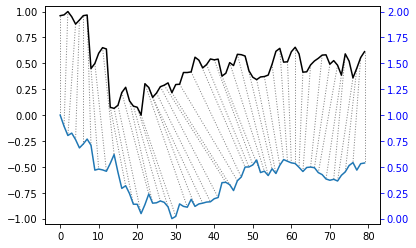

data points:  79
start date:  2022-04-04  end date:  2022-09-15
Euclidean Baseline-Euclidean Distance:  3.97
Pearson Correlation:  0.67
---------------MODEL-----------------------


c:\Users\dinud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


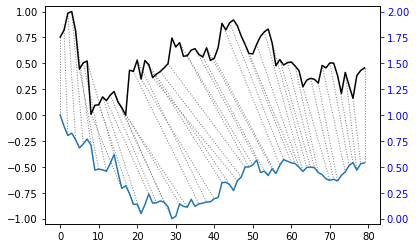

data points:  79
start date:  2022-04-04  end date:  2022-09-15
Euclidean Baseline-Euclidean Distance:  2.77
Pearson Correlation:  0.02
---------------VADER-----------------------


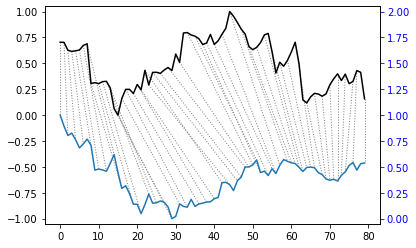

data points:  79
start date:  2022-04-04  end date:  2022-09-15
Euclidean Baseline-Euclidean Distance:  2.71
Pearson Correlation:  -0.02
---------------BERT-----------------------
-----
[0.6586428  0.00129817 0.34005898]


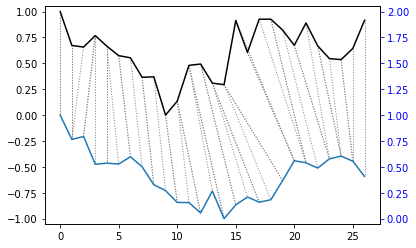

data points:  26
start date:  2022-04-05  end date:  2022-09-06
Euclidean Baseline-Euclidean Distance:  1.50
Pearson Correlation:  0.32
---------------MODEL-----------------------


c:\Users\dinud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


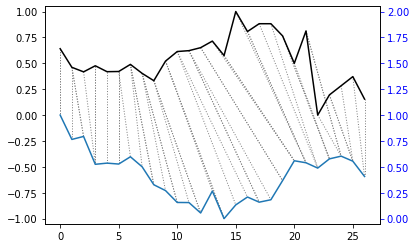

data points:  26
start date:  2022-04-05  end date:  2022-09-06
Euclidean Baseline-Euclidean Distance:  1.10
Pearson Correlation:  -0.44
---------------VADER-----------------------


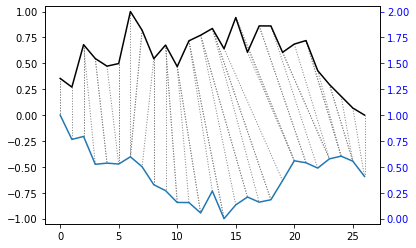

data points:  26
start date:  2022-04-05  end date:  2022-09-06
Euclidean Baseline-Euclidean Distance:  0.96
Pearson Correlation:  -0.42
---------------BERT-----------------------
-----
[0.29114312 0.7041525  0.0047043 ]


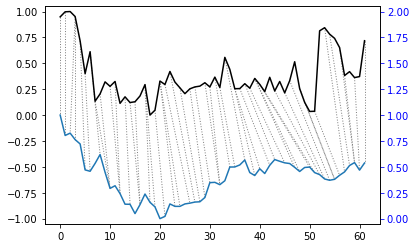

data points:  61
start date:  2022-04-04  end date:  2022-09-15
Euclidean Baseline-Euclidean Distance:  3.30
Pearson Correlation:  0.55
---------------MODEL-----------------------


c:\Users\dinud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


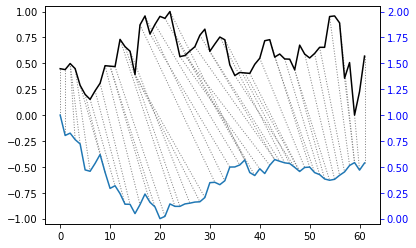

data points:  61
start date:  2022-04-04  end date:  2022-09-15
Euclidean Baseline-Euclidean Distance:  1.74
Pearson Correlation:  -0.55
---------------VADER-----------------------


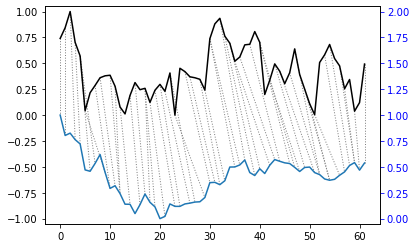

data points:  61
start date:  2022-04-04  end date:  2022-09-15
Euclidean Baseline-Euclidean Distance:  3.11
Pearson Correlation:  0.43


In [5]:

#load bert model
bert_model = tf.saved_model.load('my_model2')

topics,dates,data_f,stock_file  = load_data() 
topics = ['all','twitter','tesla']

for topic in topics:

    print("---------------BERT-----------------------")
    euclid_dist_baseline, euclid, pearcorr, mind, maxd = sentiment_stock(topic,dates,data_f, stock_file, 'bert')
    #print("For topic: ", topic, " | and stock: ", stock_file)
    print("start date: ", mind, " end date: ", maxd)

    print("Euclidean Baseline-Euclidean Distance: ", f'{(euclid_dist_baseline-euclid):.2f}')

    #print("Pearson correlation: -1 to 1. 1 or -1 is linear correlation in minus or plus direction whilst 0 is no correlation")
    print("Pearson Correlation: ", f'{pearcorr:.2f}')  

    print("---------------MODEL-----------------------")
    euclid_dist_baseline, euclid, pearcorr, mind, maxd = sentiment_stock(topic,dates,data_f, stock_file,  'model')
    #print("For topic: ", topic, " | and stock: ", stock_file)
    print("start date: ", mind, " end date: ", maxd)

    print("Euclidean Baseline-Euclidean Distance: ", f'{(euclid_dist_baseline-euclid):.2f}')

    #print("Pearson correlation: -1 to 1. 1 or -1 is linear correlation in minus or plus direction whilst 0 is no correlation")
    print("Pearson Correlation: ", f'{pearcorr:.2f}')

    print("---------------VADER-----------------------")
    euclid_dist_baseline, euclid, pearcorr, mind, maxd = sentiment_stock(topic,dates,data_f, stock_file, 'vader')
    #print("For topic: ", topic, " | and stock: ", stock_file)
    print("start date: ", mind, " end date: ", maxd)

    print("Euclidean Baseline-Euclidean Distance: ", f'{(euclid_dist_baseline-euclid):.2f}')

    #print("Pearson correlation: -1 to 1. 1 or -1 is linear correlation in minus or plus direction whilst 0 is no correlation")
    print("Pearson Correlation: ", f'{pearcorr:.2f}')
